# Modelos de regresión (simple y múltiple)

Este cuaderno muestra cómo:
- Cargar datos desde un archivo CSV.
- Entrenar una **regresión lineal simple** (una sola característica explicativa).
- Entrenar una **regresión lineal múltiple** (múltiples características, incluyendo categóricas con one-hot encoding).
- Evaluar con MSE, MAE y R², e inspeccionar coeficientes.

Ajusta la ruta del CSV y los nombres de columnas en las celdas de configuración según tu dataset.


In [17]:
# Configuración de la ruta y columnas
from pathlib import Path
import pandas as pd

# Ruta del CSV (ajústala a tu archivo)
# Ejemplos en el workspace: notebooks/Classification Models/Salary_dataset.csv, notebooks/Global_Cybersecurity_Threats_2015-2024.csv, etc.
CSV_PATH = Path(r'C:\Users\INMORTAL\OneDrive\Documentos\python\notebooks\modelos\Global_Cybersecurity_Threats_2015-2024.csv')

# Para regresión simple: una columna X y una columna objetivo y
COL_X_SIMPLE = 'Number of Affected Users'    # variable explicativa
COL_Y = 'Financial Loss (in Million $)'      # variable objetivo

# Para regresión múltiple: varias columnas X (numéricas y/o categóricas)
COLS_X_MULTIPLE = [
    'Year',
    'Country',
    'Attack Type',
    'Target Industry',
    'Number of Affected Users',
    'Attack Source',
    'Security Vulnerability Type',
    'Defense Mechanism Used'
]

# Carga de datos
if not CSV_PATH.exists():
    raise FileNotFoundError(f'No existe el CSV en: {CSV_PATH.resolve()}')

df = pd.read_csv(CSV_PATH)
print('Shape:', df.shape)
print('Columnas:', list(df.columns))
df.head()


Shape: (3000, 10)
Columnas: ['Country', 'Year', 'Attack Type', 'Target Industry', 'Financial Loss (in Million $)', 'Number of Affected Users', 'Attack Source', 'Security Vulnerability Type', 'Defense Mechanism Used', 'Incident Resolution Time (in Hours)']


,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours)
0,China,2019,Phishing,Education,80.53,773169,Hacker Group,Unpatched Software,VPN,63
1,China,2019,Ransomware,Retail,62.19,295961,Hacker Group,Unpatched Software,Firewall,71
2,India,2017,Man-in-the-Middle,IT,38.65,605895,Hacker Group,Weak Passwords,VPN,20
3,UK,2024,Ransomware,Telecommunications,41.44,659320,Nation-state,Social Engineering,AI-based Detection,7
4,Germany,2018,Man-in-the-Middle,IT,74.41,810682,Insider,Social Engineering,VPN,68


--- Regresión lineal simple ---
Coeficiente (beta): [-3.73453324e-07]
Intercepción: 50.61300638097053
MSE: 808.9102336252276
MAE: 24.609167373431095
R2 : -0.00034208499642574


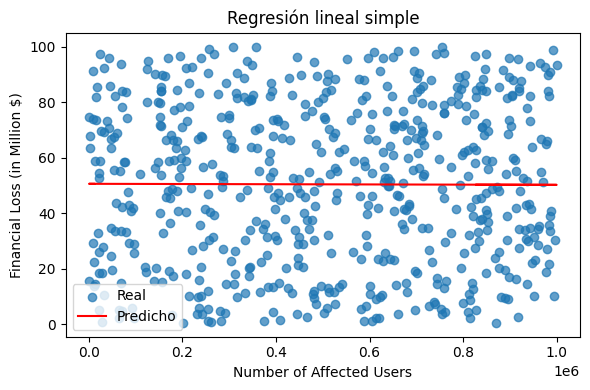

In [18]:
# Regresión lineal simple
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Selección de X e y
if COL_X_SIMPLE not in df.columns or COL_Y not in df.columns:
    raise ValueError('Revisa COL_X_SIMPLE y COL_Y. No existen en el DataFrame.')

X_simple = df[[COL_X_SIMPLE]].dropna()
y_simple = df.loc[X_simple.index, COL_Y]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_simple, y_simple, test_size=0.2, random_state=42
)

# Modelo
model_simple = LinearRegression()
model_simple.fit(X_train, y_train)

# Predicción y métricas
y_pred = model_simple.predict(X_test)
print('--- Regresión lineal simple ---')
print('Coeficiente (beta):', model_simple.coef_)
print('Intercepción:', model_simple.intercept_)
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2 :', r2_score(y_test, y_pred))

# Gráfico de dispersión y recta ajustada
plt.figure(figsize=(6,4))
plt.scatter(X_test[COL_X_SIMPLE], y_test, alpha=0.7, label='Real')
plt.plot(X_test[COL_X_SIMPLE], y_pred, color='red', label='Predicho')
plt.xlabel(COL_X_SIMPLE)
plt.ylabel(COL_Y)
plt.title('Regresión lineal simple')
plt.legend()
plt.tight_layout()
plt.show()


## Regresión lineal múltiple


In [19]:
# Regresión lineal múltiple con preprocesamiento (numéricas + categóricas)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Determina columnas numéricas y categóricas a partir de COLS_X_MULTIPLE
for col in COLS_X_MULTIPLE:
    if col not in df.columns:
        raise ValueError(f'La columna {col} no existe en el DataFrame.')
if COL_Y not in df.columns:
    raise ValueError('Revisa COL_Y. No existe en el DataFrame.')

X_mult = df[COLS_X_MULTIPLE].copy()
y_mult = df[COL_Y].copy()

# Separar por tipo
dtypes = X_mult.dtypes
num_features = [c for c in X_mult.columns if dtypes[c].kind in ['i', 'u', 'f']]
cat_features = [c for c in X_mult.columns if c not in num_features]

# Preprocesamiento: OneHot para categóricas, passthrough para numéricas
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('num', 'passthrough', num_features)
    ]
)

pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LinearRegression())
])

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_mult, y_mult, test_size=0.2, random_state=42
)

pipe.fit(X_train_m, y_train_m)

y_pred_m = pipe.predict(X_test_m)
print('--- Regresión lineal múltiple ---')
print('MSE:', mean_squared_error(y_test_m, y_pred_m))
print('MAE:', mean_absolute_error(y_test_m, y_pred_m))
print('R2 :', r2_score(y_test_m, y_pred_m))

# Extraer coeficientes (requiere obtener los nombres de las características tras OneHot)
# Nota: Esto funciona cuando el preprocesamiento ha sido ajustado
feature_names = []
if cat_features:
    ohe: OneHotEncoder = pipe.named_steps['preprocess'].named_transformers_['cat']
    ohe_names = list(ohe.get_feature_names_out(cat_features))
    feature_names.extend(ohe_names)
feature_names.extend(num_features)

coef = pipe.named_steps['model'].coef_
intercept = pipe.named_steps['model'].intercept_
print('Intercepción:', intercept)

# Mostrar los coeficientes pareados con nombre de feature
coef_table = sorted(zip(feature_names, coef), key=lambda x: -abs(x[1]))
for name, c in coef_table[:20]:  # muestra los 20 más influyentes
    print(f'{name}: {c:.4f}')


--- Regresión lineal múltiple ---
MSE: 808.9102336257085
MAE: 24.609167373427336
R2 : -0.0003420849970203754
Intercepción: 50.61300635514264
Number of Affected Users: -0.0000
Year: 0.0000
Attack Source_Insider: -0.0000
Target Industry_Education: -0.0000
Target Industry_Government: 0.0000
Country_India: -0.0000
Defense Mechanism Used_Antivirus: 0.0000
Country_Germany: 0.0000
Attack Type_DDoS: 0.0000
Attack Type_Malware: -0.0000
Attack Source_Unknown: 0.0000
Attack Type_Ransomware: -0.0000
Attack Source_Nation-state: 0.0000
Defense Mechanism Used_Firewall: -0.0000
Defense Mechanism Used_VPN: -0.0000
Country_China: -0.0000
Target Industry_IT: 0.0000
Target Industry_Healthcare: -0.0000
Attack Type_Phishing: 0.0000
Country_USA: 0.0000


## OLS con Statsmodels (estadísticas detalladas)

Ahora usamos `statsmodels` para obtener estadísticas detalladas del modelo OLS, incluyendo p-valores, intervalos de confianza y más métricas.


=== OLS SIMPLE CON STATSMODELS ===
                                  OLS Regression Results                                 
Dep. Variable:     Financial Loss (in Million $)   R-squared:                       0.000
Model:                                       OLS   Adj. R-squared:                 -0.000
Method:                            Least Squares   F-statistic:                  0.009571
Date:                           Fri, 17 Oct 2025   Prob (F-statistic):              0.922
Time:                                   10:53:13   Log-Likelihood:                -14337.
No. Observations:                           3000   AIC:                         2.868e+04
Df Residuals:                               2998   BIC:                         2.869e+04
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                               coef    std err          t      P>

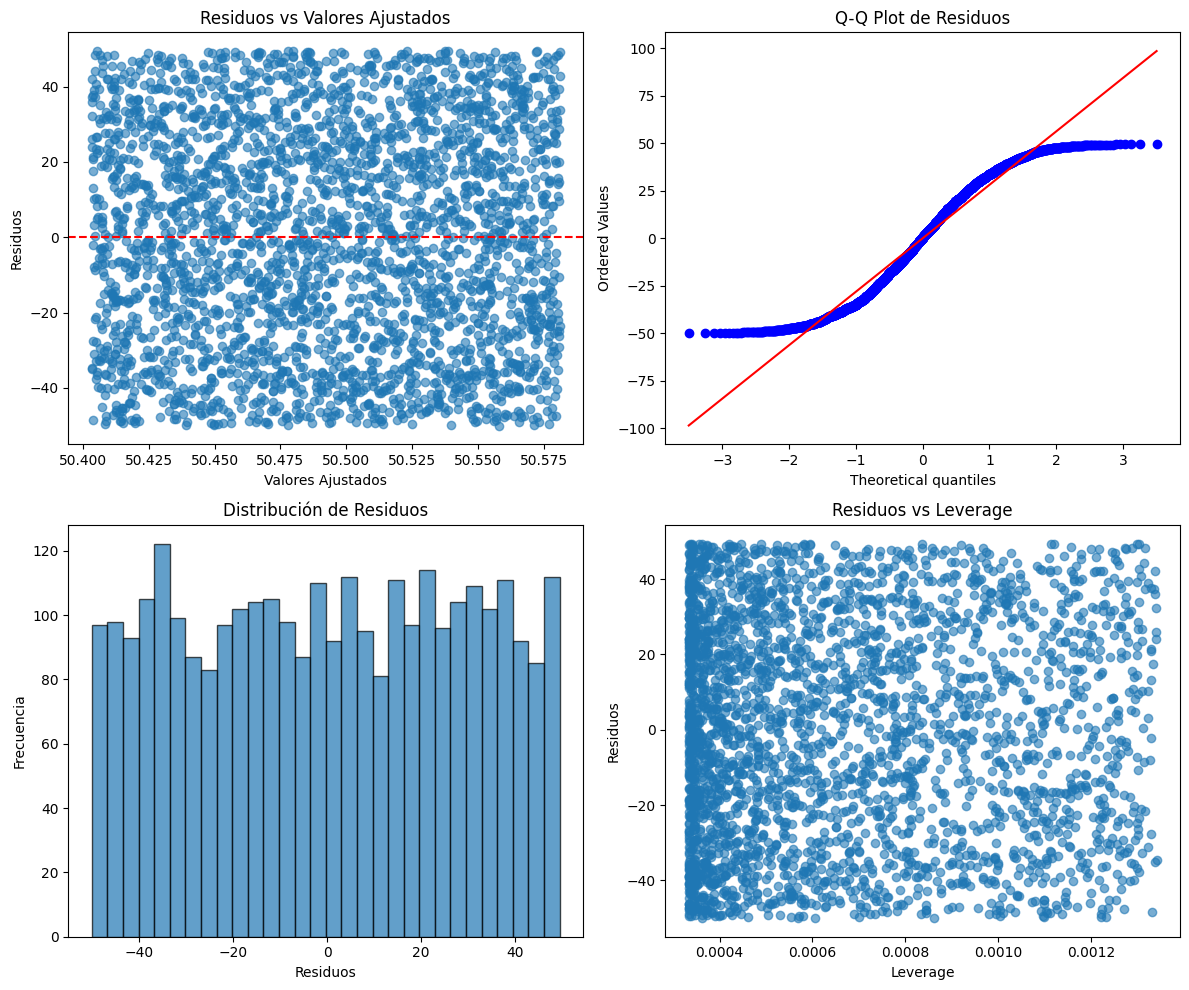

In [20]:
# OLS Simple con Statsmodels
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import warnings
warnings.filterwarnings('ignore')

print("=== OLS SIMPLE CON STATSMODELS ===")

# Preparar datos para OLS simple
X_simple_ols = sm.add_constant(X_simple)  # Agregar constante (intercepto)
y_simple_ols = y_simple

# Crear y ajustar modelo OLS
model_ols_simple = sm.OLS(y_simple_ols, X_simple_ols).fit()

# Mostrar resumen completo
print(model_ols_simple.summary())

# Diagnósticos adicionales
print("\n=== DIAGNÓSTICOS OLS SIMPLE ===")
print(f"R² ajustado: {model_ols_simple.rsquared_adj:.4f}")
print(f"AIC: {model_ols_simple.aic:.2f}")
print(f"BIC: {model_ols_simple.bic:.2f}")
print(f"Log-Likelihood: {model_ols_simple.llf:.2f}")

# Test de heterocedasticidad (Breusch-Pagan)
bp_stat, bp_pvalue, _, _ = het_breuschpagan(model_ols_simple.resid, X_simple_ols)
print(f"Test Breusch-Pagan (heterocedasticidad): estadístico={bp_stat:.4f}, p-valor={bp_pvalue:.4f}")

# Test de Durbin-Watson (autocorrelación)
dw_stat = durbin_watson(model_ols_simple.resid)
print(f"Test Durbin-Watson (autocorrelación): {dw_stat:.4f}")

# Gráficos de diagnóstico
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Residuals vs Fitted
axes[0,0].scatter(model_ols_simple.fittedvalues, model_ols_simple.resid, alpha=0.6)
axes[0,0].axhline(y=0, color='r', linestyle='--')
axes[0,0].set_xlabel('Valores Ajustados')
axes[0,0].set_ylabel('Residuos')
axes[0,0].set_title('Residuos vs Valores Ajustados')

# 2. Q-Q plot
from scipy import stats
stats.probplot(model_ols_simple.resid, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot de Residuos')

# 3. Histograma de residuos
axes[1,0].hist(model_ols_simple.resid, bins=30, alpha=0.7, edgecolor='black')
axes[1,0].set_xlabel('Residuos')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].set_title('Distribución de Residuos')

# 4. Residuals vs Leverage
from statsmodels.stats.outliers_influence import OLSInfluence
influence = OLSInfluence(model_ols_simple)
axes[1,1].scatter(influence.hat_matrix_diag, model_ols_simple.resid, alpha=0.6)
axes[1,1].set_xlabel('Leverage')
axes[1,1].set_ylabel('Residuos')
axes[1,1].set_title('Residuos vs Leverage')

plt.tight_layout()
plt.show()



=== OLS MÚLTIPLE CON STATSMODELS ===
                                  OLS Regression Results                                 
Dep. Variable:     Financial Loss (in Million $)   R-squared:                       0.010
Model:                                       OLS   Adj. R-squared:                 -0.001
Method:                            Least Squares   F-statistic:                    0.9020
Date:                           Fri, 17 Oct 2025   Prob (F-statistic):              0.626
Time:                                   10:53:14   Log-Likelihood:                -14322.
No. Observations:                           3000   AIC:                         2.871e+04
Df Residuals:                               2967   BIC:                         2.891e+04
Df Model:                                     32                                         
Covariance Type:                       nonrobust                                         
                 coef    std err          t      P>|t|      [0

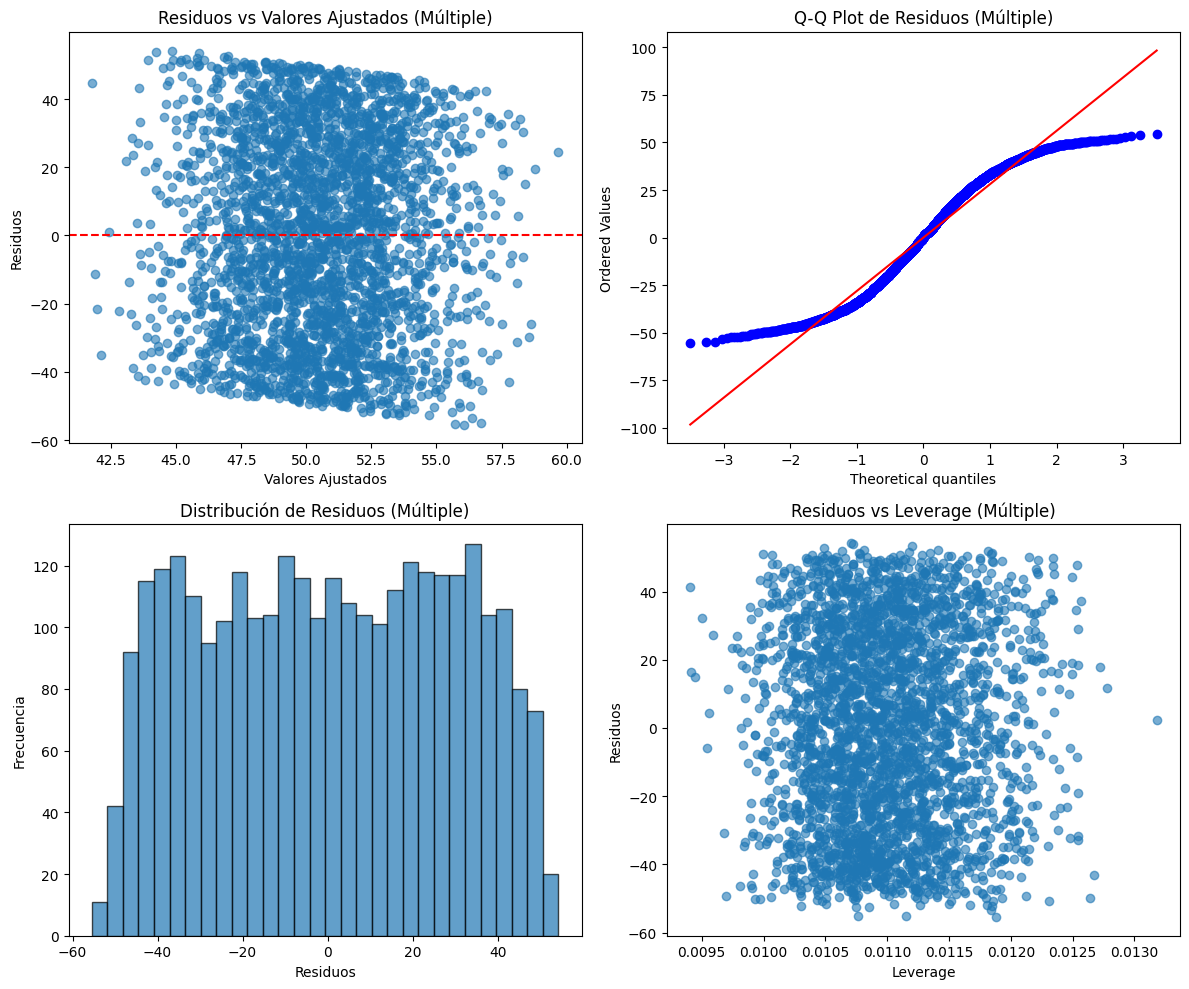

In [21]:
# OLS Múltiple con Statsmodels
print("\n=== OLS MÚLTIPLE CON STATSMODELS ===")

# Preparar datos para OLS múltiple
# Primero necesitamos aplicar el mismo preprocesamiento que usamos con scikit-learn
X_mult_processed = preprocess.fit_transform(X_mult)
feature_names_processed = []

# Obtener nombres de características después del preprocesamiento
if cat_features:
    ohe = preprocess.named_transformers_['cat']
    ohe_names = list(ohe.get_feature_names_out(cat_features))
    feature_names_processed.extend(ohe_names)
feature_names_processed.extend(num_features)

# Convertir matriz dispersa a densa si es necesario
if hasattr(X_mult_processed, 'toarray'):
    X_mult_processed = X_mult_processed.toarray()

# Agregar constante
X_mult_ols = sm.add_constant(X_mult_processed)
y_mult_ols = y_mult

# Crear y ajustar modelo OLS múltiple
model_ols_multiple = sm.OLS(y_mult_ols, X_mult_ols).fit()

# Mostrar resumen completo
print(model_ols_multiple.summary())

# Diagnósticos adicionales
print("\n=== DIAGNÓSTICOS OLS MÚLTIPLE ===")
print(f"R² ajustado: {model_ols_multiple.rsquared_adj:.4f}")
print(f"AIC: {model_ols_multiple.aic:.2f}")
print(f"BIC: {model_ols_multiple.bic:.2f}")
print(f"Log-Likelihood: {model_ols_multiple.llf:.2f}")

# Test de heterocedasticidad (Breusch-Pagan)
bp_stat, bp_pvalue, _, _ = het_breuschpagan(model_ols_multiple.resid, X_mult_ols)
print(f"Test Breusch-Pagan (heterocedasticidad): estadístico={bp_stat:.4f}, p-valor={bp_pvalue:.4f}")

# Test de Durbin-Watson (autocorrelación)
dw_stat = durbin_watson(model_ols_multiple.resid)
print(f"Test Durbin-Watson (autocorrelación): {dw_stat:.4f}")

# Mostrar coeficientes más significativos
print("\n=== COEFICIENTES MÁS SIGNIFICATIVOS ===")
coef_df = model_ols_multiple.summary2().tables[1]
coef_df_sorted = coef_df.sort_values('P>|t|')
print(coef_df_sorted.head(10))

# Test F para la significancia global del modelo
print(f"\nTest F (significancia global): F={model_ols_multiple.fvalue:.4f}, p-valor={model_ols_multiple.f_pvalue:.4f}")

# Gráficos de diagnóstico para OLS múltiple
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Residuals vs Fitted
axes[0,0].scatter(model_ols_multiple.fittedvalues, model_ols_multiple.resid, alpha=0.6)
axes[0,0].axhline(y=0, color='r', linestyle='--')
axes[0,0].set_xlabel('Valores Ajustados')
axes[0,0].set_ylabel('Residuos')
axes[0,0].set_title('Residuos vs Valores Ajustados (Múltiple)')

# 2. Q-Q plot
stats.probplot(model_ols_multiple.resid, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot de Residuos (Múltiple)')

# 3. Histograma de residuos
axes[1,0].hist(model_ols_multiple.resid, bins=30, alpha=0.7, edgecolor='black')
axes[1,0].set_xlabel('Residuos')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].set_title('Distribución de Residuos (Múltiple)')

# 4. Residuals vs Leverage
influence_mult = OLSInfluence(model_ols_multiple)
axes[1,1].scatter(influence_mult.hat_matrix_diag, model_ols_multiple.resid, alpha=0.6)
axes[1,1].set_xlabel('Leverage')
axes[1,1].set_ylabel('Residuos')
axes[1,1].set_title('Residuos vs Leverage (Múltiple)')

plt.tight_layout()
plt.show()


## Comparación entre Scikit-learn y Statsmodels

A continuación comparamos los resultados de ambos enfoques para verificar que son equivalentes.


In [22]:
# Comparación de resultados
print("=== COMPARACIÓN DE RESULTADOS ===")

# Regresión simple
print("REGRESIÓN SIMPLE:")
print(f"Scikit-learn - R²: {r2_score(y_test, y_pred):.6f}")
print(f"Statsmodels  - R²: {model_ols_simple.rsquared:.6f}")
print(f"Scikit-learn - Intercepto: {model_simple.intercept_:.6f}")
print(f"Statsmodels  - Intercepto: {model_ols_simple.params['const']:.6f}")
print(f"Scikit-learn - Coeficiente: {model_simple.coef_[0]:.6f}")
print(f"Statsmodels  - Coeficiente: {model_ols_simple.params[COL_X_SIMPLE]:.6f}")

print("\nREGRESIÓN MÚLTIPLE:")
print(f"Scikit-learn - R²: {r2_score(y_test_m, y_pred_m):.6f}")
print(f"Statsmodels  - R²: {model_ols_multiple.rsquared:.6f}")
print(f"Scikit-learn - Intercepto: {intercept:.6f}")
print(f"Statsmodels  - Intercepto: {model_ols_multiple.params['const']:.6f}")

print("\n=== VENTAJAS DE STATSMODELS ===")
print("✓ Estadísticas detalladas (p-valores, intervalos de confianza)")
print("✓ Tests de diagnóstico (heterocedasticidad, autocorrelación)")
print("✓ Métricas de información (AIC, BIC)")
print("✓ Análisis de influencia y outliers")
print("✓ Tests de significancia estadística")
print("✓ Mejor para análisis estadístico formal")

print("\n=== VENTAJAS DE SCIKIT-LEARN ===")
print("✓ Integración con pipeline de ML")
print("✓ Más rápido para predicciones")
print("✓ Mejor para modelos de producción")
print("✓ API consistente con otros algoritmos")
print("✓ Mejor para machine learning automatizado")


=== COMPARACIÓN DE RESULTADOS ===
REGRESIÓN SIMPLE:
Scikit-learn - R²: -0.000342
Statsmodels  - R²: 0.000003
Scikit-learn - Intercepto: 50.613006
Statsmodels  - Intercepto: 50.403428
Scikit-learn - Coeficiente: -0.000000
Statsmodels  - Coeficiente: 0.000000

REGRESIÓN MÚLTIPLE:
Scikit-learn - R²: -0.000342
Statsmodels  - R²: 0.009635
Scikit-learn - Intercepto: 50.613006
Statsmodels  - Intercepto: -94.016950

=== VENTAJAS DE STATSMODELS ===
✓ Estadísticas detalladas (p-valores, intervalos de confianza)
✓ Tests de diagnóstico (heterocedasticidad, autocorrelación)
✓ Métricas de información (AIC, BIC)
✓ Análisis de influencia y outliers
✓ Tests de significancia estadística
✓ Mejor para análisis estadístico formal

=== VENTAJAS DE SCIKIT-LEARN ===
✓ Integración con pipeline de ML
✓ Más rápido para predicciones
✓ Mejor para modelos de producción
✓ API consistente con otros algoritmos
✓ Mejor para machine learning automatizado
